In [1]:
from PIL import Image
from IPython.display import Image as DPImage
import os
import numpy as np
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import random
import csv
import skimage

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import L2, L1, L1L2

seed = 2023
np.random.seed(seed)  

# Useful Functions

In [2]:
def display_img(image, title=''):
    plt.title(title)
    plt.imshow(tf.keras.utils.array_to_img(image))
    plt.axis('off')
    plt.show()

def plot_history(history, model_path, steps_per_epoch = 0, y_axis_lower_bound = -1):
    
    if steps_per_epoch >0:
        xvals = int(steps_per_epoch)*np.array(history.epoch)
        xlab = 'Weight update steps'
    else:
        xvals = np.array(history.epoch)
        xlab = 'Epochs'


    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.xlabel(xlab)
    plt.ylabel('Accuracy')
    plt.plot(xvals, np.array(history.history['accuracy']),'g-', 
             label='Train accuracy')
    plt.plot(xvals, np.array(history.history['val_accuracy']),'r-',
             label = 'Validation accuracy')
    if y_axis_lower_bound>-1:
        plt.ylim([y_axis_lower_bound,1])
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel(xlab)
    plt.ylabel('Loss minimised by model')
    plt.plot(xvals, np.array(history.history['loss']),'g-', 
             label='Train loss')
    plt.plot(xvals, np.array(history.history['val_loss']),'r-',
             label = 'Validation loss')
    plt.legend()
    plt.savefig(model_path + '/results.png')

def plot_history_iou(history, steps_per_epoch = 0, y_axis_lower_bound = -1):
    
    if steps_per_epoch >0:
        xvals = int(steps_per_epoch)*np.array(history.epoch)
        xlab = 'Weight update steps'
    else:
        xvals = np.array(history.epoch)
        xlab = 'Epochs'
    
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.xlabel(xlab)
    plt.ylabel('IOU')
    plt.plot(xvals, np.array(history.history['mean_iou']),'g-', 
             label='Train IOU')
    plt.plot(xvals, np.array(history.history['val_mean_iou']),'r-',
             label = 'Validation IOU')
    if y_axis_lower_bound>-1:
        plt.ylim([y_axis_lower_bound,1])
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel(xlab)
    plt.ylabel('Loss minimised by model')
    plt.plot(xvals, np.array(history.history['loss']),'g-', 
             label='Train loss')
    plt.plot(xvals, np.array(history.history['val_loss']),'r-',
             label = 'Validation loss')
    plt.legend()
    
def diceloss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, y_pred.dtype)
    intersection = K.sum(K.abs(y_true * y_pred))
    dice = (2*intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
    return 1 - dice

def iou(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou = K.mean((intersection + 1) / (union + 1))
    return iou

def mean_iou(y_true, y_pred):
    results = []   
    for t in np.arange(0.5, 1, 0.05):
        t_y_pred = tf.cast((y_pred > t), tf.float32)
        pred = iou(y_true, t_y_pred)
        results.append(pred)
        
    return K.mean(K.stack(results))

# Load Pre-Processed Data Croppings
see preprocessing.ipynb

In [3]:
def loadCroppings(data_dir, image_croppings_dir, mask_croppings_dir=""):
    height = 128
    width = 128
    image_ids = os.listdir(data_dir)
    
    croppings_count = np.zeros(len(image_ids), dtype=np.uint8)
    
    X_size = 0
    Y_size = 0
    
    for i, imgID in enumerate(image_ids):
        path_images = f"{data_dir}/{imgID}/{image_croppings_dir}"
        X_size += len(sorted(os.listdir(path_images)))
        if mask_croppings_dir:
            path_masks = f"{data_dir}/{imgID}/{mask_croppings_dir}"
            Y_size += len(sorted(os.listdir(path_masks)))
    
    X = np.zeros((X_size, height, width, 3), dtype=np.uint8)
    Y = np.zeros((Y_size, height, width), dtype=np.bool_)
    
    j, k = 0, 0
    idx_dict = {}
    images = []
    for i, imgID in enumerate(image_ids):
        path_images = f"{data_dir}/{imgID}/{image_croppings_dir}"
        croppings = sorted(os.listdir(path_images))
        croppings_count[i] = len(croppings)
        idx_j = [j]
        for c in croppings:
            img = tf.convert_to_tensor(Image.open(f"{path_images}/{c}"))
            X[j] = np.stack((img,)*3, axis=-1)
            j+=1
            idx_j.append(j)
        idx_dict[imgID] = idx_j[:-1]
            

        if mask_croppings_dir:
            path_masks = f"{data_dir}/{imgID}/{mask_croppings_dir}"
            
            for c in sorted(os.listdir(path_masks)):
                Y[k] = tf.convert_to_tensor(Image.open(f"{path_masks}/{c}"))
                #Y[k] = np.stack((mask,)*3, axis=-1)
                k+=1
                
        # original images
        path_images = f"{data_dir}/{imgID}/images"
        image = tf.keras.utils.load_img(f"{path_images}/{os.listdir(path_images)[0]}")
        images.append(image)
        
    return X, Y, image_ids, idx_dict, images

In [4]:
X_train, Y_train, imageIDs_train,_ , _ = loadCroppings("./data/stage1_train", "image_croppings", "mask_croppings")
X_val, Y_val, imageIDs_val,_ , _  = loadCroppings("./data/stage1_test", "image_croppings", "mask_croppings")

# # Only Load During Testing
# # X_test, _, imageIDs_test,_ , images_test  = loadCroppings("./data/stage2_test_final", "image_croppings")

2023-05-08 17:31:44.784702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30999 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


In [5]:
len(X_train) #7315

7315

Cropping


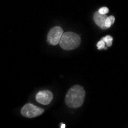

[[2 2 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]
 [2 0 0 ... 2 0 3]
 ...
 [0 0 0 ... 2 6 8]
 [0 0 0 ... 2 6 6]
 [0 0 0 ... 5 5 5]]
Mask


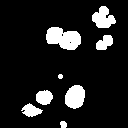

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [6]:
print("Cropping")
display(Image.fromarray(X_train[12][:,:,0], 'L'))
print(X_train[12][:,:,0])
print("Mask")
display(Image.frombytes(mode='1', size=Y_train[0].shape, data=np.packbits(Y_train[12], axis=1)))
print(Y_train[12])

# Train Model

In [7]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    #x = Dropout(rate=0.2)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    #x = Dropout(rate=0.5)(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [16]:
def UNet_ResNet(inputs_shape, LR):
    
    inputs = Input(inputs_shape, name="input")
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    resnet50.trainable = False
    
    # Encoder
    s1 = resnet50.get_layer("input").output             # (128 x 128) 3
    s2 = resnet50.get_layer("conv1_relu").output        # (64 x 64) 64
    s3 = resnet50.get_layer("conv2_block3_out").output  # (32 x 32) 256
    s4 = resnet50.get_layer("conv3_block4_out").output  # (16 x 16) 512
    
    
    # Bridge
    b1 = resnet50.get_layer("conv4_block6_out").output  # (8 x 8) 1024
    
    # Decoder
    d1 = decoder_block(b1, s4, 512)                     # (16 x 16)
    d2 = decoder_block(d1, s3, 256)                      # (32 x 32)
    d3 = decoder_block(d2, s2, 128)                      # (64 x 64)
    d4 = decoder_block(d3, s1, 64)                      # (128 x 128)
    
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    
    model = keras.models.Model(inputs, outputs)
    
    model.compile(loss=diceloss,
                  optimizer=Adam(learning_rate=LR),
                  metrics=[mean_iou])
    
    return model


In [17]:
batch_size = 64
batches_per_epoch = int(len(X_train)/batch_size) 
epochs = 25
LR = 0.0001
stopping_patience = 10
stopping_delta = 0.001

In [18]:
input_shape = (128, 128, 3)
model = UNet_ResNet(input_shape, LR)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input[0][0]']                  
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [11]:
stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_iou',
                                                     patience=stopping_patience, 
                                                     min_delta=stopping_delta,
                                                     verbose = 1,
                                                     restore_best_weights=True)



results = model.fit(X_train, Y_train, 
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,  
                    validation_data=(X_val, Y_val),
                    callbacks = [stopping_callback],
                    shuffle=True)

Epoch 1/25


2023-05-08 17:35:21.673862: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


115/115 [==============================] - 51s 187ms/step - loss: 0.4154 - mean_iou: 0.6457 - val_loss: 0.4947 - val_mean_iou: 0.6469
Epoch 2/25
115/115 [==============================] - 19s 166ms/step - loss: 0.2037 - mean_iou: 0.8493 - val_loss: 0.2958 - val_mean_iou: 0.7366
Epoch 3/25
115/115 [==============================] - 19s 167ms/step - loss: 0.1449 - mean_iou: 0.8669 - val_loss: 0.2215 - val_mean_iou: 0.7370
Epoch 4/25
115/115 [==============================] - 19s 167ms/step - loss: 0.1238 - mean_iou: 0.8735 - val_loss: 0.2022 - val_mean_iou: 0.7243
Epoch 5/25
115/115 [==============================] - 19s 167ms/step - loss: 0.1101 - mean_iou: 0.8779 - val_loss: 0.2137 - val_mean_iou: 0.6823
Epoch 6/25
115/115 [==============================] - 19s 167ms/step - loss: 0.0992 - mean_iou: 0.8830 - val_loss: 0.1933 - val_mean_iou: 0.7105
Epoch 7/25
115/115 [==============================] - 19s 167ms/step - loss: 0.0916 - mean_iou: 0.8861 - val_loss: 0.1896 - val_mean_iou: 0.7

In [28]:
model_savepath = "/data/gent/450/vsc45006/model1"  
model.save(model_savepath)

INFO:tensorflow:Assets written to: /data/gent/450/vsc45006/model8/assets


/apps/gent/RHEL8/cascadelake-volta-ib/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/apps/gent/RHEL8/cascadelake-volta-ib/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Training set IoU: 0.6924
Training set Loss:0.502388

Validation set IoU: 0.6550
Validation set Loss:0.503385



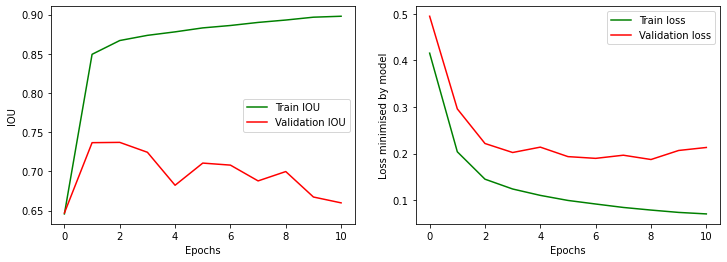

In [12]:
[train_loss, train_accuracy] = model.evaluate(X_train, Y_train, verbose=0)
print("Training set IoU:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_accuracy] = model.evaluate(X_val, Y_val, verbose=0)
print("Validation set IoU:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

plot_history_iou(results)

## Testing

In [1]:
# Load Test Data
X_test, _, imageIDs_test,_ , images_test = loadCroppings("./data/stage2_test_final", "image_croppings")

NameError: name 'loadCroppings' is not defined

In [ ]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_val, verbose=1)
preds_test = model.predict(X_test, verbose=1)

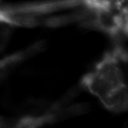

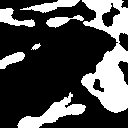

In [18]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)[:,:,:,0]
preds_val_t = (preds_val > 0.5).astype(np.uint8)[:,:,:,0]
preds_test_t = (preds_test > 0.5).astype(np.uint8)[:,:,:,0]

ix = random.randint(0, len(preds_test_t))
display(Image.fromarray(X_test[ix], 'L'))
# display(Image.frombytes(mode='1', size=Y_val.shape[1:], data=np.packbits(Y_val[ix], axis=1)))
display(Image.frombytes(mode='1', size=preds_test_t.shape[1:], data=np.packbits(preds_test_t[ix], axis=1)))

In [19]:
ix

876

In [ ]:
# test_savepath = "./data/Train_1"  

# model.save(test_savepath)

## Export Predicted masks to CSV

In [20]:
testset_predictions = (preds_test > 0.5).astype(np.uint8)

Saving 42697 predictions
0019c086029dd3be01f72131edb74e21ee995574e6d5c136ea868630b0d73523


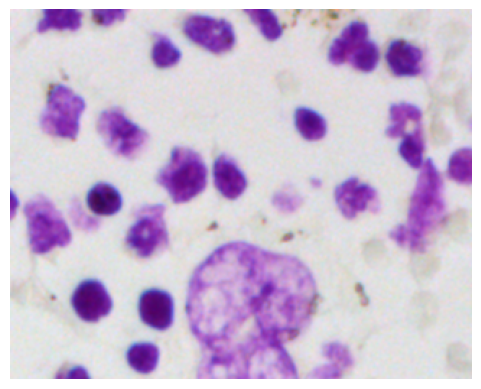

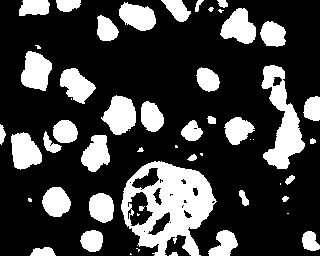

004a078bb44ee55ee7d6f1c19f96b3a0d3b5037746a3a75197dbb0be06da05cf


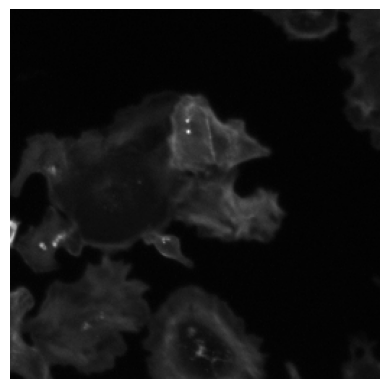

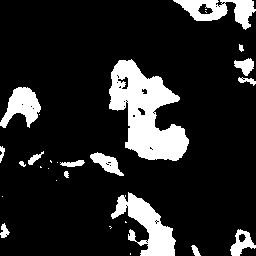

005463e6d4a0a0b21161f1d97392f22556fbddba970d9440ae774229308a91ed


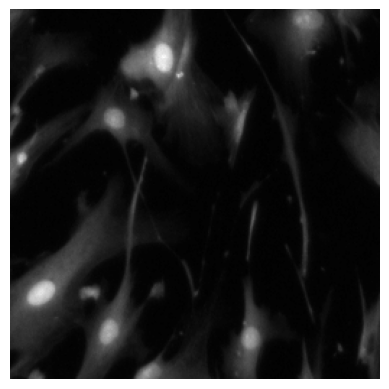

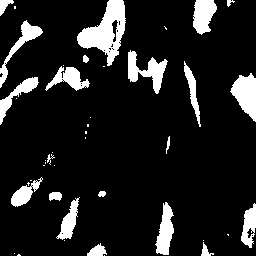

005af293e8e53218ae96746ecf9bb88b511154d4a0b35e4ec6296b4623e15836


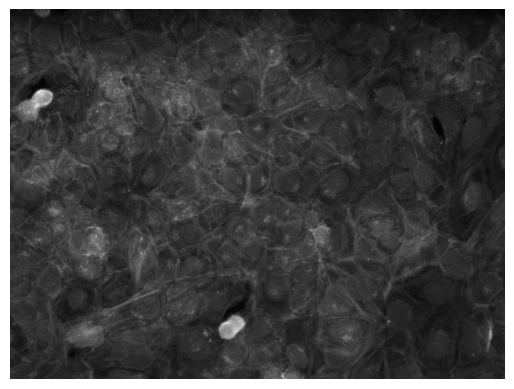

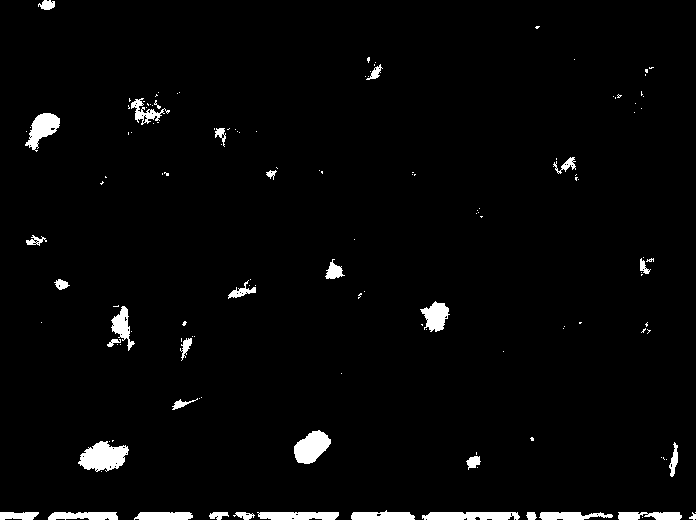

005d47447abac7f7fa0ac56ba82f13edbf485105baf0672504d84b58d562f38b


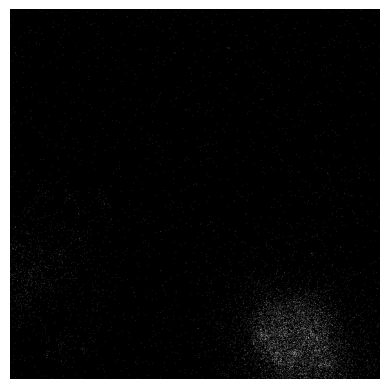

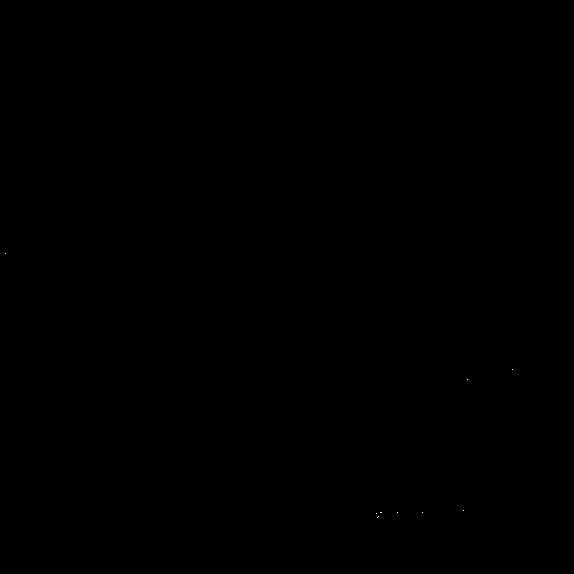

00ac87390253a22f6eb67c5771a73050e06200d1aa682fcf1b1e3783b2944166


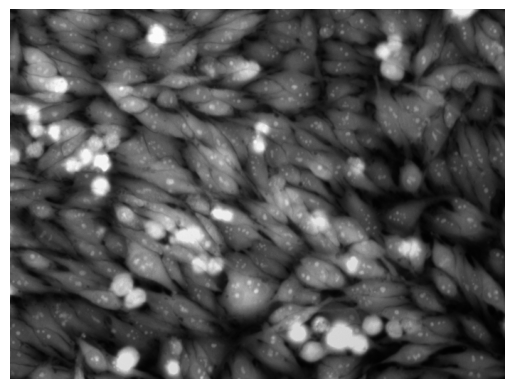

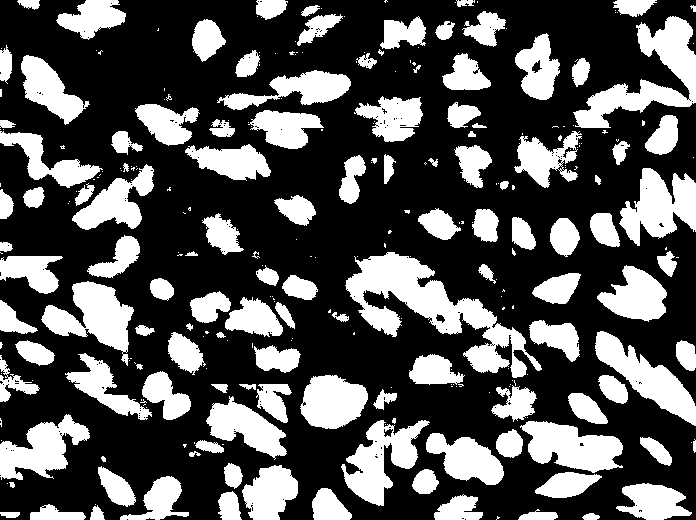

00b4b9c026cfc91af21691503bad67081fc02d5c77b3cd27200d02dca6966b83


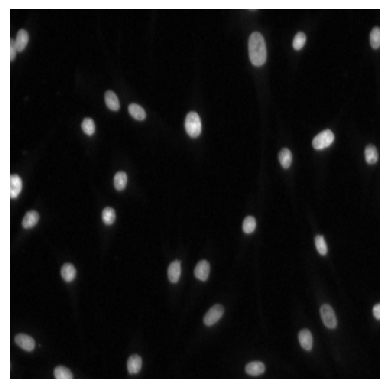

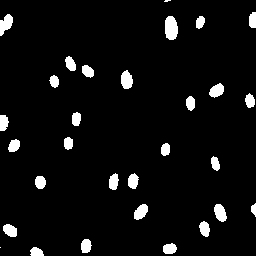

00da4fe5346bbb36ccf178964a22fdf7e33888989624176a6af3b4a7cfd7da63


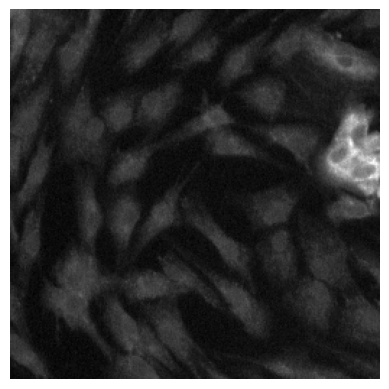

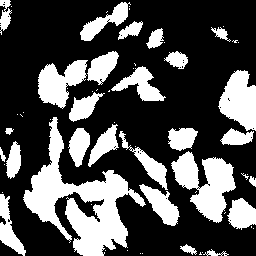

00e36f2470960e84cfc9f0d30c1f76abd7b35e4516380bf74985cbe641086806


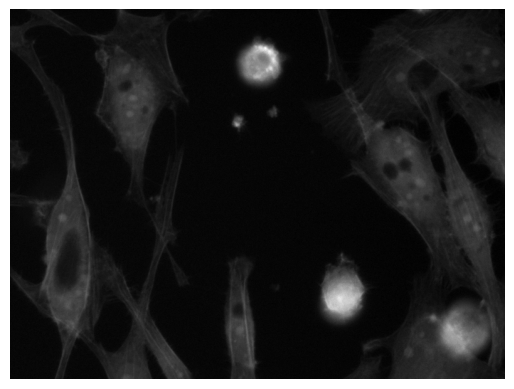

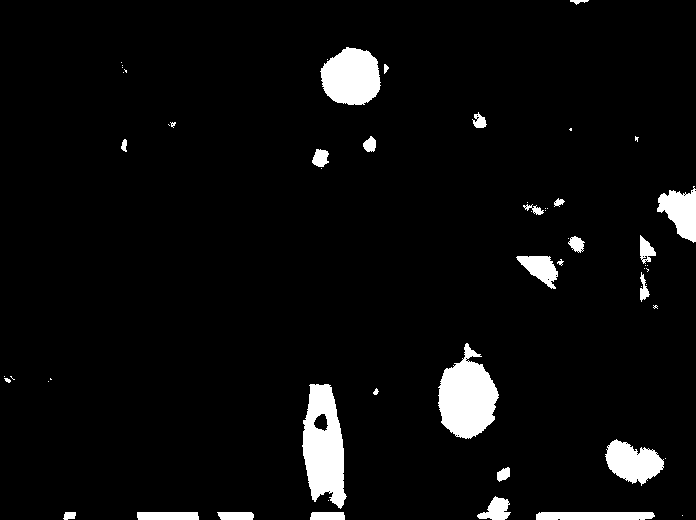

5%

Found 235757 nuclei in 42697 images


In [22]:
template_csv = "./data/stage2_sample_submission_final.csv"
image_dir = "./data/stage2_test_final"
output_csv = "./data/submission_test.csv"

show_no_nuclei_images = False

print(f"Saving {testset_predictions.shape[0]} predictions")
with open(output_csv, 'w', newline='') as output_csvfile:
    writer = csv.DictWriter(output_csvfile, fieldnames=["ImageId", "EncodedPixels"])
    writer.writeheader()
    total_nucleus_count = 0
    
    progress_indices = np.linspace(0, testset_predictions.shape[0], 21, dtype=int)
    
    with open(template_csv, newline='') as template_csvfile:
        for i, (imgID, _) in enumerate(csv.reader(template_csvfile, delimiter=',')):
            if i == 0: # Skip row with labels
                continue

            # Get Prediction For ImgID
            idx_img = idx_test[imgID]
            prediction = testset_predictions[idx_img,:,:,0]
            mask_size = prediction[0].shape
            mask_height = mask_size[0]
            mask_width = mask_size[1]

            # TODO reconstruct mask predictions into original size
            # original_image_size = Image.open(f"{image_dir}/{imgID}/images/{os.listdir(f'{image_dir}/{imgID}/images')[0]}").size
            
            idx = imageIDs_test.index(imgID) # all index for cropped mask
            original_image_size = images_test[idx].size
            n_y = int(np.ceil(original_image_size[1]/mask_height))
            n_x = int(np.ceil(original_image_size[0]/mask_width))

            original_mask = np.zeros((mask_height*n_y, mask_width*n_x), dtype=int)

            for i_y in range(n_y):
                for i_x in range(n_x):
                    original_mask[i_y*mask_height: (i_y+1)*mask_height, i_x*mask_width: (i_x+1)*mask_width] = prediction[i_y*n_x+ i_x]

            predicted_mask = original_mask[0:original_image_size[1], 0:original_image_size[0]]
            if i < 10:
                print(imgID)
                display_img(images_test[idx])
                Image.frombytes(mode='1', size=predicted_mask.shape[::-1], data=np.packbits(predicted_mask, axis=1)).show()

            # # Get Prediction For ImgID
            # prediction = testset_predictions[imageIDs_test.index(imgID)]
            # # Scale Predicted Mask Back To Original Image Size
            # original_image_size = Image.open(f"{image_dir}/{imgID}/images/{os.listdir(f'{image_dir}/{imgID}/images')[0]}").size
            # predicted_mask = tf.keras.utils.img_to_array(
            #     tf.image.resize(prediction, original_image_size, method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            # )[:, :, 0]
            
            predicted_mask_T = predicted_mask.transpose()
            
            # Label each nucleus in mask
            (labeled_mask, nucleus_amount) = skimage.measure.label(predicted_mask_T, connectivity=2, background=0, return_num=True)
            total_nucleus_count += nucleus_amount
            if nucleus_amount == 0 and show_no_nuclei_images:
                print(f"No nuclei found for image {imgID}")
                try:
                    # display_img(Image.open(f"{image_dir}/{imgID}/images/{os.listdir(f'{image_dir}/{imgID}/images')[0]}"))
                    display_img(images_test[idx])
                except:
                    print(f"Error while displaying image {imgID}")
            
            # Calculate RLE
            RLE = [[] for _ in range(nucleus_amount)]
            curr_pixel = 1
            run_length = 0
            run_label = 0
            
            for i_c, c in enumerate(labeled_mask):
                for i_r, x in enumerate(c):
                    if x:
                        if run_length == 0 or run_label != x:
                            if run_length > 0:
                                RLE[run_label-1].append(run_length)
                                run_length = 0
                            RLE[x-1].append(i_c * labeled_mask.shape[1] + i_r + 1)
                            run_label = x
                        run_length += 1
                    elif run_length > 0:
                        RLE[run_label-1].append(run_length)
                        run_length = 0
                        run_label = 0
            if run_length > 0:
                RLE[run_label-1].append(run_length)
            
            # Write To output file
            for nucleus_RLE in RLE:
                writer.writerow({"ImageId": imgID, "EncodedPixels": ' '.join(map(str, nucleus_RLE))})
            
            if nucleus_amount == 0: # default entry
                writer.writerow({"ImageId": imgID, "EncodedPixels": ''})
            
            # Show sign of progress
            if i in progress_indices:
                print(f"{np.where(progress_indices == i)[0][0] * 5}%")
    
    print()
    print(f"Found {total_nucleus_count} nuclei in {testset_predictions.shape[0]} images")

#### Architectures to try out 

Attention U-net

Residual U-Net

Mask R-CNN

Basic Unet + ResNet encoder